# Lab Assignments 2 and 3 with Frozen Lake Grid Environment

<p style="color:blue;">
By Pramod Sharma : pramod.sharma@prasami.com<br>
<p>
    
<p style="color:red;">
Do not <strong>Remove</strong> any cell!!!<br>
<p>

**Submitted by** <br />
**Name:** Kanumuri Sri Naga Sai Ajith (You can call me Ajith 😊) <br />
**PRN:** 200240128012

In [ ]:
# Import statements
import os
import random

import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from collections import defaultdict

import seaborn as sns

from time import sleep
from IPython.display import clear_output, display

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# Parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

# Global Parameters
RANDOM_STATE = 24

alpha = 0.01 #0.85
gamma = 0.90
epsilon = 0.8

 ## Load Frozen Lake Environment

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 8 x 8 grid world. 
States $S$ are from 0 to 63

SFFFFFFF       (S: starting point, safe)<br>
FFFFFFFF       (F: frozen surface, safe)<br>
FFFHFFFF       (H: hole, fall to your doom)<br>
FFFFFHFF       (G: goal, where the frisbee is located)<br>
FFFHFFFF<br>
FHHFFFHF<br>
FHFFHFHF<br>
FFFHFFFG <br>

<img src='./images/Frozenlake8x8.png' style='width:400px;'>

In [ ]:
# Make the environment based on non-deterministic policy. 
# Standard configuration is loaded
env = gym.make('FrozenLake8x8-v0')
env.seed(RANDOM_STATE)
env.reset()
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


## Helper Function
### Feel Free to add modify as per your design

<h3>Note</h3>
I modified fn_display a bit in order to render final frame as well. - Ajith

In [ ]:
def fn_plot_heatmap(values, opt_policy):
    '''
    Plot value function in on the grid
    Args:
        values : np array of shape (8,8)
        opt_policy: one hot encoded policy, numpy array of shape (64,4) 
    return : None
    '''
    fig, ax = plt.subplots()
    act = [action_mappings[action] for action in np.argmax(opt_policy, axis=1)]
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(8,8)

    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
    plt.show()


def fn_display(opt_policy):
    '''
    Function to visualise how agent behaves under given policy
    Args:
        opt_policy: one hot encoded policy, numpy array of shape (64,4)
    '''
    points = 0
    for i_episode in range(10): # run 10 episodes
        observation = env.reset()
        while True: # run until episode is done
            clear_output(wait=True)
            print ('Episode number:{} Score {}'.format(i_episode, points))
            env.render()
            sleep(0.1)
            action = np.argmax(policy[observation])
            observation, reward, done, info = env.step(action)
            points += reward
            if done:
                clear_output(wait=True)
                print('All episodes complete. Score {}'.format(points))
                env.render()
                break

# Action mappings - Map actions to numbers
'''
    Needed in fn_plot_heatmap
    Note: these mappings are only for ornamental purpose 
    and do not contribute to programming logic 
'''
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


In [ ]:
'''
    Dry Run of the environment
'''
# Go right once (action = 2), we should go to the right but we did not!
env.reset()
action = 2
observation, reward, done, prob = env.step(action)
env.render()
print (observation, reward, done, prob)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
8 0.0 False {'prob': 0.3333333333333333}


## Assignment 2
Code TD Prediction as per following algorithm


<img src='./images/TD_prediction_algorithm.JPG' style='width:600px;'>

Create a policy $\pi$ either random or with any other logic. Provide clear explanation of your policy

In [ ]:
def fn_random_policy(state):
    '''
    Policy to be evaluated. Random policy has been implemented.
    Args:
        state: current state of the environment.
    Returns: an action to be done by the agent.
    '''
    return random.randint(0, 3)

def td_prediction(policy_fn, env, n_episodes, alpha=alpha, gamma=gamma):
    '''
    Performs prediction task for the given policy in the given environment.
    In other words, this function evaluates the provided policy function 
    in the given environment.
    Args:
        policy_fn: a function of policy to be evaluated
        env: an environment in which policy will be evaluated
        n_episodes: number of episodes to be run for evaluation
        alpha (optional): learning rate or step-size of agent
        gamma (optional): discount rate of agent
    Returns: a numpy array of state values
    '''
    values = np.zeros((64,))
    for episode in tqdm(range(n_episodes)):
        state = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            next_state, reward, done, info = env.step(action)
            values[state] = values[state] + alpha * (reward + gamma * values[next_state] - values[state])
            state = next_state
    return values.reshape(8, 8)

def fn_plot_heatmap_of_values(values):
    '''
    Plot obtained state values in a grid.
    Args:
        values: a numpy array of state values
    Returns: None
    '''
    fig, ax = plt.subplots()
    labels = np.asarray(["{0:.5f}".format(v) for v in values.ravel()]).reshape(8, 8)
    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn')
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:56<00:00, 859.44it/s]


[[2.38746187e-05 3.92712582e-05 8.60614779e-05 1.69303202e-04
  3.53718333e-04 7.47954371e-04 1.17925848e-03 1.50922734e-03]
 [2.00007999e-05 2.93440358e-05 5.73424751e-05 1.40175660e-04
  3.91037032e-04 8.67126852e-04 1.85391402e-03 2.61684465e-03]
 [1.39018364e-05 1.83193677e-05 1.92764089e-05 0.00000000e+00
  4.21619220e-04 1.19829511e-03 3.27927780e-03 5.97315571e-03]
 [9.26533822e-06 1.31196198e-05 2.17501159e-05 5.87353815e-05
  2.42910898e-04 0.00000000e+00 7.03242409e-03 1.54744884e-02]
 [5.04905136e-06 6.39239326e-06 6.88325057e-06 0.00000000e+00
  6.65878633e-04 2.51842256e-03 1.19314144e-02 4.32167722e-02]
 [1.71378476e-06 0.00000000e+00 0.00000000e+00 6.47738671e-05
  3.66691086e-04 9.05404174e-04 0.00000000e+00 1.43888671e-01]
 [5.36855551e-07 0.00000000e+00 3.90926024e-07 4.09300713e-06
  0.00000000e+00 1.42974950e-03 0.00000000e+00 4.05188447e-01]
 [2.41845951e-07 8.92895821e-08 9.42343688e-08 0.00000000e+00
  2.84513628e-04 8.82063977e-03 6.70814539e-02 0.00000000e+00]]

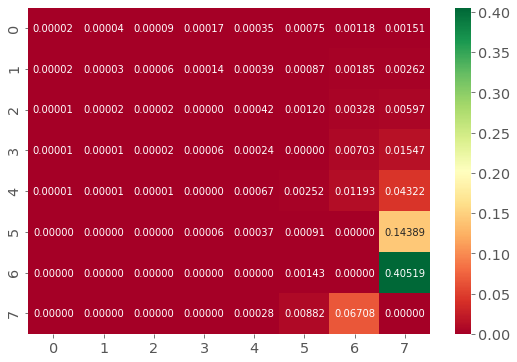

In [ ]:
random.seed(RANDOM_STATE) # For reproducibility, a seed needs to be passed to random number generator
values = td_prediction(fn_random_policy, env, n_episodes=100000) # evaluation of random policy
sleep(0.1) # pause the execution for a small amount time in order to not break the progress bar of tqdm
print(values)
fn_plot_heatmap_of_values(values) # a visualization of state values

## Assignment 3
Code  Sarsa (on-policy TD control) for estimating Q = $q_*$


<img src='./images/SARSA.png' style='width:600px;'>

In [ ]:
def fn_e_greedy_policy(state, q, epsilon=epsilon):
    '''
    Function for epsilon-greedy policy.
    Args:
        state: current state of the environment
        q: current estimate of action values
        epsilon (optional): value of epsilon
    Returns: action to be performed by the agent
    '''
    if random.random() < epsilon:
        return random.randint(0, 3)
    else:
        current_q = q[state, :]
        return custom_argmax(current_q)

def custom_argmax(array):
    '''
    A custom argmax function. Numpy's implementation of argmax
    always selects the element nearer to the beginning if there
    are multiple maximum elements. This implementation rectifies
    that for us.
    Args:
        array: a numpy array of action values in a state
    Returns: optimal action to be performed
    '''
    indices = np.array(range(len(array)))
    max_indices = indices[array == np.max(array)]
    return random.choice(max_indices)

def sarsa_control(policy_fn, env, n_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma):
    '''
    Implementation of SARSA algorithm for control
    Args:
        policy_fn: function of agent's policy
        env: gym environment object
        n_episodes: number of episodes
        alpha (optional): learning rate or step-size of the agent
        epsilon (optional): value of epsilon which affects exploration and exploitation
        gamma (optional): discount rate of the agent
    Returns:
        q: numpy array of action values learned by the agent
    '''
    q = np.zeros((64, 4))
    for episode in tqdm(range(n_episodes)):
        state = env.reset()
        action = policy_fn(state, q, epsilon)
        done = False
        while not done:
            next_state, reward, done, info = env.step(action)
            next_action = policy_fn(next_state, q, epsilon)
            td_target = reward + gamma * q[next_state, next_action]
            td_error = td_target - q[state, action]
            q[state, action] = q[state, action] + alpha * td_error
            state = next_state
            action = next_action
    return q

def q_to_onehot_policy(q):
    '''
    Converts action values to onehot encoded policy
    Args:
        q: numpy array of action values
    Returns:
        policy: numpy array of onehot encoded policy
    '''
    policy = np.zeros((64, 4))
    for i in range(64):
        policy[i, np.argmax(q[i, :])] = 1
    return policy

def q_to_values(q):
    '''
    Converts action values to state values
    Args:
        q: numpy array of action values
    Returns:
        values: numpy array of state values
    '''
    values = np.zeros((64, ))
    for state in range(64):
        current_q = q[state, :]
        values[state] = np.max(current_q)
    return values.reshape(8, 8)

def tune_parameters(alpha_list, epsilon_list, gamma_list, policy_fn=fn_e_greedy_policy, env=env):
    '''
    A helper function to tune the parameters. Performs grid search on provided
    parameter values.
    Args:
        alpha_list: a list of alpha values to be considered
        epsilon_list: a list of epsilon values to be considered
        gamma_list: a list of gamma values to be considered
        policy_fn (optional): function of agent's policy
        env (optional): gym environment object
    Returns:
        best_params: a tuple of best parameters
        score_dict: a dictionary of scores obtained by all combinations of parameters
    '''
    from itertools import product
    score_dict = dict()
    param_list = list(product(alpha_list, epsilon_list, gamma_list))
    for alpha, epsilon, gamma in tqdm(param_list):
        q = np.zeros((64, 4))
        current_params = (alpha, epsilon, gamma)
        score_dict[current_params] = 0
        for episode in range(1000):
            state = env.reset()
            action = policy_fn(state, q, epsilon)
            done = False
            while not done:
                next_state, reward, done, info = env.step(action)
                score_dict[current_params] += reward
                next_action = policy_fn(next_state, q, epsilon)
                td_target = reward + gamma * q[next_state, next_action]
                td_error = td_target - q[state, action]
                q[state, action] = q[state, action] + alpha * td_error
                state = next_state
                action = next_action
    best_params = max(score_dict.keys(), key=lambda k: score_dict[k])
    return best_params, score_dict

In [ ]:
alpha_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 1.0]
epsilon_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 1.0]
gamma_list = [0.8, 0.9, 0.95, 0.99]
best_params, score_dict = tune_parameters(alpha_list, epsilon_list, gamma_list)
b_alpha, b_epsilon, b_gamma = best_params
sleep(0.1) # pause the execution for small amount of time in order to not break the progress bar of tqdm
print(f'best alpha = {b_alpha}\nbest_epsilon = {b_epsilon}\nbest_gamma = {b_gamma}')

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [11:44<00:00,  1.96s/it]

best alpha = 0.25
best_epsilon = 0.1
best_gamma = 0.99


The following cell shows whether there are any other parameters that obtained the same score as our best parameters and prints the best score.

In [ ]:
print([params for params in score_dict if score_dict[params] == score_dict[best_params]])
best_score = score_dict[best_params]
print('Best Score = {}'.format(best_score))

[(0.25, 0.1, 0.99)]
Best Score = 140.0


Now that we saw what the best score is and confirmed that there are no other set of parameters which achieve the best score, lets train our agent using the obtained best parameters.

In [ ]:
q = sarsa_control(fn_e_greedy_policy, env, n_episodes=100000, alpha=b_alpha, epsilon=b_epsilon, gamma=b_gamma)
policy = q_to_onehot_policy(q)
plot_grid = q_to_values(q)
fn_display(policy)

All episodes complete. Score 10.0
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


WOW!!! Our agent succeeded in all 10 episodes! Time to celebrate and see the learned policy of the agent.

### Evaluation
Your submission should sucessfully plot heatmap for evaluation of the assignment
Use Bellman Optimality Equaltion for State-Value Function
<img src='./images/Bellman_Optimality_Equation.png'>

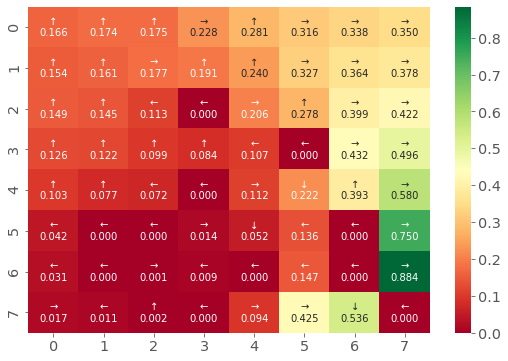

In [ ]:
fn_plot_heatmap(plot_grid, policy)